In [11]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

SEED = 1337
random.seed(SEED)

In [12]:
df = pd.read_csv("../../data/data_raw/blogs.csv")
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [13]:
df.drop(["id", "gender", "age", "topic", "sign", "date"], axis=1, inplace=True)
df["text"] = df["text"].str.strip()

In [14]:
df.isna().sum()

text    0
dtype: int64

In [15]:
df["length"] = df["text"].str.len()

In [16]:
df = df[df["length"] >= 50]

<Axes: >

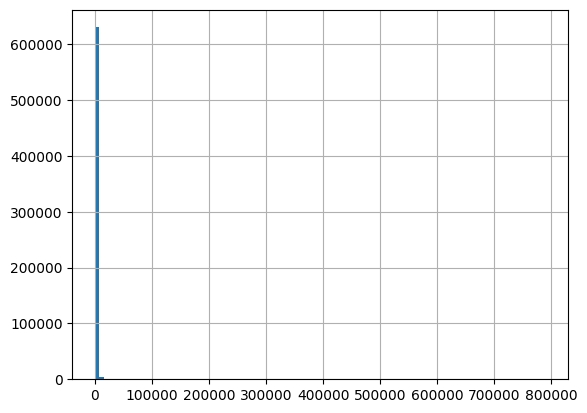

In [17]:
df["length"].hist(bins=100)

In [18]:
df.duplicated(subset="text").sum()

np.int64(58690)

In [19]:
df.drop_duplicates(subset="text", inplace=True)

In [40]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [41]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful asistant for rewritting blogs. Based on provided blog generate a similar one. MAKE SURE TO REPLAY ONLY WITH THE SIMILAR BLOG."},
                {"role": "user", "content": "Blog: \n {blog} \n"},
                {"role": "assistant", "content": "Similar blog: \n"}]

In [42]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(blog=blog)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for blog in df["text"].values
]

In [43]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [44]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

 44%|████▍     | 2195/4955 [02:58<03:22, 13.63it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (145329 > 131072). Running this sequence through the model will result in indexing errors
4956it [07:00, 11.78it/s]                          


In [45]:
too_large = [i for i, l in enumerate(lens) if l > 32_768]
too_large

[29217,
 96583,
 255734,
 280960,
 357346,
 372888,
 432857,
 493399,
 549186,
 589471,
 613687]

In [46]:
too_large = [31751, 103745, 275622, 302666, 384759, 401258, 465417, 529872, 589853, 632880, 658665]
df.drop(["length"], axis=1, inplace=True)
df.drop(too_large, inplace=True)
df.to_csv("../../data/data_human/blogs.csv", index=False)

In [8]:
prompts = [prompts[i] for i in range(len(prompts)) if i not in too_large]

In [9]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=40_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=40_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=40_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=40_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=40_000, seed=SEED),  # Highly Creative
]

In [10]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/blogs/blogs_"

In [11]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-14 23:36:01 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-14 23:36:15 config.py:542] This model supports multiple tasks: {'reward', 'score', 'generate', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 02-14 23:36:15 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-14 23:36:28 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-14 23:36:31 worker.py:267] Memory profiling takes 2.38 seconds
INFO 02-14 23:36:31 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-14 23:36:31 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-14 23:36:31 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-14 23:36:31 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-14 23:37:08 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s]

INFO 02-14 23:37:40 model_runner.py:1562] Graph capturing finished in 32 secs, took 0.12 GiB
INFO 02-14 23:37:40 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 72.62 seconds



  0%|          | 0/85159 [00:00<?, ?it/s]

INFO 02-14 23:37:41 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/85159 [00:45<543:29:47, 22.98s/it]


In [12]:
df = pd.read_csv("../../data/data_ai/blogs/blogs_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",**Upload Process Update: Our Team Leader is Wo...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",**Team Member Profiles: A Look into the Talent...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...",**How to Build a Nuclear Power Plant: A Step-b...,1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",**Testing: The Ultimate Guide to Ensuring the ...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...",**Discover the Melody of Korea: 24-Hour K-Pop ...,1.2,0.7,20
